## Robo-Stock Portfolio Advisor
### Portfolio Strategy Chosen: Market Meet
### Delivers a portfolio that returns closely to the benchmark average consisting of S&P500 and TSX60

In [1]:
from IPython.display import display, Math, Latex

import random
import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from collections import defaultdict

### Stock Filtering Procedure

Before constructing the LSTM prediction model and running the Monte Carlo
portfolio simulation, it is necessary to restrict the initial batch of
stocks to a set of reliable, liquid, and stable candidates.  
This filtering step ensures that the remaining tickers are suitable for
forecasting and portfolio optimization.

#### Why We Need Filtering

The raw CSV file often contains many stocks that may be:
- too volatile,
- thinly traded,
- delisted or inactive,
- or denominated in unsupported currencies.

Including such stocks would:
1. **Distort volatility measurements**,  
2. **Reduce prediction accuracy**,  
3. **Increase simulation noise**,
4. **Produce unrealistic portfolios** that cannot be executed in real markets.

Therefore, a filtering mechanism is required to ensure that only
statistically stable and tradable securities are passed downstream into the
model.

The filter downloads historical prices and volumes, computing daily return volatility and evaluating monthly trading activity, keeping only months with at least 18 trading days. Additionally, it calculates comprehensive growth metrics including multi-timeframe momentum (3-month, 6-month, and 12-month), revenue growth, profit margins, return on equity, earnings growth, volume trends, and relative strength versus the S&P~500 benchmark. These metrics are combined into a composite performance score that identifies stocks most likely to perform well while maintaining reasonable risk profiles. The filter also enforces sector distribution and market cap constraints, requiring stocks to have sufficient average monthly volume and trade in either USD or CAD. Only securities that meet all criteria are retained, after which those with the highest composite scores, balancing growth potential with fundamental quality, are selected for further modeling.

In [2]:
start_date = "2022-05-01"
end_date = "2025-11-22"

In [3]:
def calculate_growth_metrics(ticker):
    """Calculate multiple growth indicators for any stock"""
    try:
        ticker_obj = yf.Ticker(ticker)
        info = ticker_obj.info
        hist = ticker_obj.history(period="2y")      
        if hist.empty or len(hist) < 100:
            return None       
        # Price Momentum (multiple timeframes)
        if len(hist) >= 60:
            momentum_3m = (hist['Close'].iloc[-1] - hist['Close'].iloc[-60]) / hist['Close'].iloc[-60]
        else:
            momentum_3m = 0
            
        if len(hist) >= 120:
            momentum_6m = (hist['Close'].iloc[-1] - hist['Close'].iloc[-120]) / hist['Close'].iloc[-120]
        else:
            momentum_6m = 0
            
        momentum_12m = (hist['Close'].iloc[-1] - hist['Close'].iloc[0]) / hist['Close'].iloc[0]
        
        # Revenue Growth
        try:
            financials = ticker_obj.financials
            if not financials.empty and 'Total Revenue' in financials.index:
                revenues = financials.loc['Total Revenue'].sort_index()
                if len(revenues) >= 2:
                    revenue_growth = (revenues.iloc[-1] - revenues.iloc[-2]) / abs(revenues.iloc[-2])
                else:
                    revenue_growth = 0
            else:
                revenue_growth = 0
        except:
            revenue_growth = 0
        
        profit_margin = info.get('profitMargins', 0)
        if profit_margin is None:
            profit_margin = 0   
        # Return on Equity
        roe = info.get('returnOnEquity', 0)
        if roe is None:
            roe = 0      
        # Forward P/E
        forward_pe = info.get('forwardPE', info.get('trailingPE', 25))
        if forward_pe is None or forward_pe <= 0:
            forward_pe = 25
        
        # Earnings Growth
        earnings_growth = info.get('earningsGrowth', 0)
        if earnings_growth is None:
            earnings_growth = 0
        
        # Volume trend (increasing interest)
        if len(hist) >= 180:
            recent_volume = hist['Volume'].iloc[-30:].mean()
            old_volume = hist['Volume'].iloc[-180:-150].mean()
            volume_trend = (recent_volume - old_volume) / old_volume if old_volume > 0 else 0
        else:
            volume_trend = 0
        
        # Price stability (avoid extreme volatility)
        volatility = hist['Close'].pct_change().std()
        # Relative Strength vs SPY
        try:
            spy_data = yf.download("SPY", period="1y", progress=False)
            if not spy_data.empty and 'Close' in spy_data.columns:
                spy = spy_data['Close']
                
                # Get matching date range
                common_dates = hist.index.intersection(spy.index)
                if len(common_dates) > 50:  # Need at least 50 days of overlap
                    stock_prices = hist.loc[common_dates, 'Close']
                    spy_prices = spy.loc[common_dates]
                    
                    # Calculate returns from first to last common date
                    stock_return = (stock_prices.iloc[-1] - stock_prices.iloc[0]) / stock_prices.iloc[0]
                    spy_return = (spy_prices.iloc[-1] - spy_prices.iloc[0]) / spy_prices.iloc[0]
                    
                    relative_strength = stock_return - spy_return
                else:
                    relative_strength = 0
            else:
                relative_strength = 0
        except Exception as e:
            relative_strength = 0
        
        return {
            'momentum_3m': float(momentum_3m),
            'momentum_6m': float(momentum_6m),
            'momentum_12m': float(momentum_12m),
            'revenue_growth': float(revenue_growth) if revenue_growth else 0,
            'profit_margin': float(profit_margin) if profit_margin else 0,
            'roe': float(roe) if roe else 0,
            'forward_pe': float(forward_pe) if forward_pe and forward_pe > 0 else 25,
            'earnings_growth': float(earnings_growth) if earnings_growth else 0,
            'volume_trend': float(volume_trend),
            'volatility': float(volatility),
            'relative_strength': float(relative_strength)
        }
    except Exception as e:
        print(f"Error in calculate_growth_metrics for {ticker}: {str(e)}")
        return None

def calculate_composite_score(metrics, vol, sector):
    """
    Calculate a composite score that predicts 2025 performance.
    Lower score = better (will sort ascending)
    """
    if metrics is None:
        return float('inf')
    
    # Weights for different factors (tune these based on what matters for 2025)
    weights = {
        'momentum_3m': 0.15,      # Recent momentum
        'momentum_6m': 0.15,      # Medium-term momentum  
        'momentum_12m': 0.10,     # Long-term momentum
        'revenue_growth': 0.15,   # Fundamental growth
        'profit_margin': 0.10,    # Quality
        'roe': 0.05,              # Efficiency
        'earnings_growth': 0.10,  # Earnings power
        'volume_trend': 0.05,     # Market interest
        'relative_strength': 0.15 # Outperformance vs market
    }
    
    # Normalize and score each metric (higher is better for all except volatility)
    score = 0
    
    # Positive factors (higher = better = lower score)
    score -= weights['momentum_3m'] * metrics['momentum_3m']
    score -= weights['momentum_6m'] * metrics['momentum_6m']
    score -= weights['momentum_12m'] * metrics['momentum_12m']
    score -= weights['revenue_growth'] * metrics['revenue_growth']
    score -= weights['profit_margin'] * metrics['profit_margin'] * 10  # Scale up
    score -= weights['roe'] * metrics['roe'] * 5  # Scale up
    score -= weights['earnings_growth'] * metrics['earnings_growth']
    score -= weights['volume_trend'] * metrics['volume_trend']
    score -= weights['relative_strength'] * metrics['relative_strength']
    
    # Penalty factors
    score += vol * 2  # Volatility penalty (but not too harsh)
    # PE penalty (avoid extreme valuations)
    if metrics['forward_pe'] > 40:
        score += 0.2
    elif metrics['forward_pe'] < 10:  # Too cheap might be a red flag
        score += 0.1
    return score

def select_high_performance_stocks(stock_df, num_stocks, min_monthly_volume):
    """
    Select stocks most likely to perform well in 2025 across all sectors.
    """
    results_list = []
    
    try:
        usd_to_cad = yf.Ticker("USDCAD=X").history(period="1d")["Close"].iloc[-1]
    except:
        usd_to_cad = 1.35
    
    print("Calculating growth metrics for all stocks...")
    
    for ticker in stock_df['Ticker']:
        try:
            ticker_obj = yf.Ticker(ticker)
            hist = ticker_obj.history(start=start_date, end=end_date)
            
            if hist.empty:
                print(f"Skipping {ticker}. No Data Found.")
                continue
            
            # Basic volatility
            hist['Daily_Return'] = hist['Close'].pct_change()
            vol = hist['Daily_Return'].std()
            
            # Monthly volume
            hist.index = hist.index.tz_localize(None)
            hist['Month'] = hist.index.to_period('M')
            monthly_vol = hist.groupby('Month')['Volume'].agg(['sum', 'count'])
            valid_months = monthly_vol[monthly_vol['count'] >= 18]
            avg_monthly_vol = valid_months['sum'].mean()
            
            # Get info
            info = ticker_obj.info
            currency = info.get('currency', None)
            sector = info.get('sector', 'Unknown')
            market_cap = info.get('marketCap', 0)
            
            # Market cap classification
            if currency == 'USD':
                market_cap_cad = market_cap * usd_to_cad
            else:
                market_cap_cad = market_cap
            
            if market_cap_cad > 10_000_000_000:
                cap_class = 'Large'
            elif market_cap_cad < 2_000_000_000:
                cap_class = 'Small'
            else:
                cap_class = 'Mid'
            
            is_valid_currency = currency in ['USD', 'CAD']
            
            if avg_monthly_vol >= min_monthly_volume and is_valid_currency:
                # Calculate comprehensive growth metrics
                growth_metrics = calculate_growth_metrics(ticker)
                
                if growth_metrics:
                    # Calculate composite score
                    composite_score = calculate_composite_score(growth_metrics, vol, sector)
                    
                    results_list.append({
                        'Ticker': ticker,
                        'Volatility': vol,
                        'Composite_Score': composite_score,
                        'Momentum_12M': growth_metrics['momentum_12m'],
                        'Revenue_Growth': growth_metrics['revenue_growth'],
                        'Profit_Margin': growth_metrics['profit_margin'],
                        'ROE': growth_metrics['roe'],
                        'Forward_PE': growth_metrics['forward_pe'],
                        'Relative_Strength': growth_metrics['relative_strength'],
                        'Average Monthly Volume': avg_monthly_vol,
                        'Sector': sector,
                        'Market Cap (CAD)': market_cap_cad,
                        'Cap Class': cap_class
                    })
                    
                    print(f"✓ {ticker}: Score={composite_score:.3f}, Momentum={growth_metrics['momentum_12m']:.2%}")
        
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    
    # Sort by composite score (lower = better)
    filtered_stocks_df = pd.DataFrame(results_list)
    filtered_stocks_df = filtered_stocks_df.sort_values(by='Composite_Score')
    
    # Apply constraints
    selected_stocks = []
    sector_counts = {}
    has_large_cap = False
    has_small_cap = False
    
    max_stocks_per_sector = int(num_stocks * 0.40)
    
    for _, row in filtered_stocks_df.iterrows():
        if len(selected_stocks) >= num_stocks:
            break
        
        ticker = row['Ticker']
        sector = row['Sector']
        cap_class = row['Cap Class']
        
        # Check sector limit
        current_sector_count = sector_counts.get(sector, 0)
        if current_sector_count >= max_stocks_per_sector:
            print(f"Skipping {ticker} - sector limit for {sector} ({current_sector_count}/{max_stocks_per_sector})")
            continue
        
        # Add stock
        selected_stocks.append(row)
        sector_counts[sector] = current_sector_count + 1
        
        if cap_class == 'Large':
            has_large_cap = True
        elif cap_class == 'Small':
            has_small_cap = True
    
    final_df = pd.DataFrame(selected_stocks)
    
    # Diagnostics
    print(f"Large-cap present: {has_large_cap}")
    print(f"Small-cap present: {has_small_cap}")
    print(f"Total stocks selected: {len(selected_stocks)}")
    print("\nSector Distribution:")
    for sector, count in sorted(sector_counts.items()):
        weight = count / len(selected_stocks)
        print(f"{sector}: {count} stocks ({weight:.1%})")
        
    return final_df, final_df['Ticker'].tolist()

In [7]:
# Read tickers file
tickers_df = pd.read_csv('Tickers.csv', header=None, names=['Ticker'])

# Run filter function
filtered_stocks, tickers = select_high_performance_stocks(
    tickers_df,
    num_stocks=24,
    min_monthly_volume=100000
)

print("Filtered Tickers Used:", tickers)

Calculating growth metrics for all stocks...


$INVALIDTIC: possibly delisted; no timezone found


Skipping INVALIDTIC. No Data Found.


$ASDFA.TO: possibly delisted; no timezone found
$  SU.TO: possibly delisted; no timezone found


Skipping asdfa.to. No Data Found.
Skipping   SU.TO. No Data Found.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ ABBV: Score=-0.400, Momentum=83.06%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ LOW: Score=-0.056, Momentum=22.70%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:28: RuntimeWarning: invalid value encountered in scalar divide
  revenue_growth = (revenues.iloc[-1] - revenues.iloc[-2]) / abs(revenues.iloc[-2])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ AUST: Score=nan, Momentum=105.84%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ TD: Score=-0.439, Momentum=46.88%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ AMZN: Score=-0.230, Momentum=50.43%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ AXP: Score=-0.384, Momentum=120.38%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ GCT: Score=-0.420, Momentum=267.93%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ BK: Score=-0.458, Momentum=137.08%


$HDFC.NS: possibly delisted; no timezone found


Skipping HDFC.NS. No Data Found.


$SQ: possibly delisted; no timezone found


Skipping SQ. No Data Found.


$CELG: possibly delisted; no timezone found


Skipping CELG. No Data Found.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ EXE.TO: Score=-0.664, Momentum=244.96%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ CMCSA: Score=-0.029, Momentum=-31.18%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ SHOP: Score=-0.060, Momentum=108.29%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ COST: Score=0.078, Momentum=57.81%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ CSCO: Score=-0.325, Momentum=67.64%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ GM: Score=-0.083, Momentum=155.72%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ GOOG: Score=-0.715, Momentum=115.47%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ AIM.TO: Score=-0.095, Momentum=-2.11%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ FTG.TO: Score=-0.271, Momentum=151.24%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ ORCL: Score=-0.465, Momentum=74.80%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ SAP.TO: Score=-0.172, Momentum=55.49%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ DUOL: Score=-1.272, Momentum=-20.95%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ PEP: Score=-0.142, Momentum=-7.39%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ T.TO: Score=-0.075, Momentum=-10.89%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ SLB: Score=0.057, Momentum=-27.34%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ SO: Score=-0.228, Momentum=37.45%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ SPG: Score=-0.651, Momentum=67.38%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ SHOP.TO: Score=-0.069, Momentum=118.00%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ COST: Score=0.078, Momentum=57.81%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ T.TO: Score=-0.075, Momentum=-10.89%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ RY.TO: Score=-0.499, Momentum=89.58%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ TD.TO: Score=-0.457, Momentum=51.11%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ AW.TO: Score=-0.261, Momentum=-2.61%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ BTC-USD: Score=-0.030, Momentum=133.27%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1401212178.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", period="1y", progress=False)


✓ VSP.TO: Score=-0.011, Momentum=44.66%
Large-cap present: True
Small-cap present: True
Total stocks selected: 24

Sector Distribution:
Basic Materials: 1 stocks (4.2%)
Communication Services: 3 stocks (12.5%)
Consumer Cyclical: 3 stocks (12.5%)
Consumer Defensive: 2 stocks (8.3%)
Financial Services: 5 stocks (20.8%)
Healthcare: 2 stocks (8.3%)
Industrials: 1 stocks (4.2%)
Real Estate: 1 stocks (4.2%)
Technology: 5 stocks (20.8%)
Utilities: 1 stocks (4.2%)
Filtered Tickers Used: ['DUOL', 'GOOG', 'EXE.TO', 'SPG', 'RY.TO', 'ORCL', 'BK', 'TD.TO', 'TD', 'GCT', 'ABBV', 'AXP', 'CSCO', 'FTG.TO', 'AW.TO', 'AMZN', 'SO', 'SAP.TO', 'PEP', 'AIM.TO', 'GM', 'T.TO', 'T.TO', 'SHOP.TO']


In [8]:
# Retrieve data from each stock in the dataframe  
def get_stock_data(ticker):
    data = yf.download(ticker, start_date, end_date)
    data = data[['Close']] #, 'Volume']]
    #data['daily_return'] = data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

# We want to store the df for each ticker as a dictionary
all_data = {}
for ticker in tickers:
    df = get_stock_data(ticker)
    all_data[ticker] = df

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\2987840679.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start_date, end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\2987840679.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start_date, end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\2987840679.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start_date, end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\2987840679.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start_date, end_date)
[********

LSTM Model:

In [9]:
# Prepare the data

scaled_data = {}

for ticker, df in all_data.items():    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_close = scaler.fit_transform(df[['Close']])

    scaled_data[ticker] = {
        'scaled': scaled_close,
        'scaler': scaler
    }

print(scaled_close.shape)

(895, 1)


In [10]:
# Creating Sequences

lookback = 60  # number of days per input sequence - window size

def create_sequences(scaled_values, lookback):
    x, y = [], []
    for i in range(lookback, len(scaled_values)):
        x.append(scaled_values[i - lookback:i, 0])  # past 60 days
        y.append(scaled_values[i, 0])  # next day return
    
    return np.array(x), np.array(y) # Convert to numpy arrays for LSTM

# Dictionary to store sequences for each ticker
sequenced_data = {}

for ticker, info in scaled_data.items():
    scaled_values = info['scaled']
    x, y = create_sequences(scaled_values, lookback)
    
    # reshape x for LSTM input
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))

    # store sequences and scaler
    sequenced_data[ticker] = {
        'scaler': info['scaler'],
        'x': x,
        'y': y
    }    

#print(x.shape, y.shape)

train_test_data = {}

for ticker, info in sequenced_data.items():
    x = info['x']
    y = info['y']
    
    # Common split: 80% training / 20% testing
    train_size = int(len(x) * 0.8)
    
    # Split sequences
    x_train, y_train = x[:train_size], y[:train_size]
    x_test, y_test = x[train_size:], y[train_size:]
    
    # Store split data
    train_test_data[ticker] = {
        'scaler': info['scaler'],
        'x_train': x_train,
        'y_train': y_train,
        'x_test': x_test,
        'y_test': y_test
    } 

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(668, 60, 1) (668,)
(167, 60, 1) (167,)


In [11]:
# Merge all tickers into one training dataset
x_train_all = []
y_train_all = []
x_test_all = []
y_test_all = []

for ticker, info in train_test_data.items():
    x_train_all.append(info['x_train'])
    y_train_all.append(info['y_train'])
    
    x_test_all.append(info['x_test'])
    y_test_all.append(info['y_test'])

# Concatenate all tickers into one dataset
x_train_all = np.concatenate(x_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)
x_test_all = np.concatenate(x_test_all, axis=0)
y_test_all = np.concatenate(y_test_all, axis=0)

print("Global training dataset:", x_train_all.shape, y_train_all.shape)
print("Global testing dataset:", x_test_all.shape, y_test_all.shape)

Global training dataset: (14808, 60, 1) (14808,)
Global testing dataset: (3703, 60, 1) (3703,)


In [12]:
# Shuffle training data so that the model learns the "general" stock behaviour
shuffle_idx = np.random.permutation(len(x_train_all))
x_train_all = x_train_all[shuffle_idx]
y_train_all = y_train_all[shuffle_idx]

In [13]:
# Building the LSTM Model

model = Sequential() # Sequential means layers are stacked in order, one after another

# First LSTM Layer (no of neurons in the layer, output a full sequence of results, shape of each training)
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(Dropout(0.2))

# Second LSTM Layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2)) # Drop 20% of neurons randomy during each training step - prevents overfitting

# Output Layer (final prediction)
# each neuron connects to all previous ones
model.add(Dense(1)) # predicting the next price

# Compile Model
# Adam (Adaptive Moment Estimation) optmizer - algorithm to adjust weights efficiently during training
# MSE (Mean squared error) - the average squared difference between predicted and true values: the lower the better
model.compile(optimizer='adam', loss='mse')

C:\Users\ADMIN\anaconda3\envs\cfm101\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
#6. Training the model

history = model.fit(
    x_train_all, y_train_all, # training data
    epochs=5, # how many times model goes through the entire training dataset
    batch_size=32, # how many samples it sees at once before updating weights
    validation_split=0.1,
    shuffle=True
)

Epoch 1/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - loss: 0.0109 - val_loss: 0.0015
Epoch 2/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 3/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 4/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 34s 82ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 5/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - loss: 0.0013 - val_loss: 7.9646e-04


In [15]:
ticker_predictions = {}

for ticker, info in train_test_data.items():
    scaler = info['scaler']
    X_test = info['x_test']
    y_test = info['y_test']

    # Model prediction (still scaled)
    scaled_pred = model.predict(X_test)

    # Inverse scale y_test and predictions
    scaled_true = y_test.reshape(-1, 1)

    true_prices = scaler.inverse_transform(scaled_true)
    pred_prices = scaler.inverse_transform(scaled_pred)

    ticker_predictions[ticker] = {
        'true': true_prices,
        'predicted': pred_prices
    }

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [16]:
summary_rows = []

for ticker in filtered_stocks["Ticker"]:
    if ticker not in ticker_predictions:
        print(f"Skipping {ticker} — no predictions found.")
        continue

    pred_array = ticker_predictions[ticker]["predicted"]
    true_array = ticker_predictions[ticker]["true"]

    last_pred = float(pred_array[-1])   # most recent predicted price
    last_true = float(true_array[-1])   # most recent actual price
    diff = last_pred - last_true

    # Get volatility + volume from filtered_stocks
    vol = filtered_stocks.loc[filtered_stocks["Ticker"] == ticker, "Volatility"].values[0]
    vol_month = filtered_stocks.loc[filtered_stocks["Ticker"] == ticker, "Average Monthly Volume"].values[0]

    summary_rows.append({
        "Ticker": ticker,
        "Volatility": vol,
        "Average Monthly Volume": vol_month,
        "Last_Price": last_true,
        "Predicted_Price": last_pred,
        "diff": diff
    })
    
final_df = pd.DataFrame(summary_rows)
final_df = final_df.sort_values(by="diff", ascending=False).reset_index(drop=True)
final_df.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\2908603292.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_pred = float(pred_array[-1])   # most recent predicted price
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\2908603292.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_true = float(true_array[-1])   # most recent actual price


,Ticker,Volatility,Average Monthly Volume,Last_Price,Predicted_Price,diff
0,ORCL,0.026081,2.138225e+08,198.759995,213.703568,14.943573
1,PEP,0.011791,1.238176e+08,146.330002,146.917023,0.587021
2,T.TO,0.010856,6.629023e+07,18.709999,19.134674,0.424675
3,T.TO,0.010856,6.629023e+07,18.709999,19.134674,0.424675
4,AIM.TO,0.020431,1.911898e+06,2.790000,2.803248,0.013248


## LSTM Model for Price Prediction

To generate short–term forecasts for each stock in the filtered batch, we
trained a Long Short-Term Memory (LSTM) neural network. LSTM models are a class
of recurrent neural networks (RNNs) specifically designed to capture temporal
dependencies in sequential data. Unlike standard RNNs, LSTMs incorporate
memory cells and gating mechanisms that allow them to retain information over
longer time horizons while mitigating vanishing–gradient issues. These
properties make LSTMs particularly effective for financial time series, where
patterns, trends, and momentum evolve over time.

We selected the LSTM architecture over alternatives such as ARIMA models or
simple feed-forward neural networks because it is better suited to modelling
non-linear dynamics and sequential dependencies in stock prices. Traditional
statistical models typically assume stationarity and linear relationships,
while LSTMs can flexibly learn complex patterns directly from the data.

The model was trained using a sliding-window approach: 

For each stock, the
previous 60 days of closing prices were used as input features, and the next
day's closing price was used as the prediction target. All price data were
scaled to the \([0,1]\) range using the MinMaxScaler to ensure numerical
stability during training. The network consisted of an LSTM layer followed by
dense layers, trained with the Adam optimizer and mean squared error (MSE)
loss.

After training, the model produced a predicted price for the most recent day
in the dataset for each stock. These predictions, along with the corresponding
actual prices, are summarized in the table below and are used as inputs to the
portfolio optimization procedure.


### Stock Market Return Calculator (Benchmark Average)

This code calculates expected return for the S&P 500 and TSX Composite using LSTM predictions

In [17]:
def get_expected_return_for_ticker(ticker, ticker_predictions=None, hist_start="2024-05-01", hist_end="2025-11-01"):
    """
    Returns expected return (%) for `ticker`.
    - If ticker_predictions dict is provided and contains this ticker, use that (last predicted vs last true).
      ticker_predictions[t]['predicted'] and ['true'] should be arrays/ndarrays.
    - Otherwise, fetch monthly closing prices and use mean monthly return to predict next price:
        predicted_price = last_price * (1 + mean_monthly_return)
      Then compute expected return = (predicted_price - last_price) / last_price * 100.
    """
    # 1) Try to use existing predictions if available
    if ticker_predictions is not None and ticker in ticker_predictions:
        try:
            pred_arr = np.asarray(ticker_predictions[ticker]['predicted']).reshape(-1)
            true_arr = np.asarray(ticker_predictions[ticker]['true']).reshape(-1)
            if pred_arr.size > 0 and true_arr.size > 0:
                last_pred = float(pred_arr[-1])
                last_true = float(true_arr[-1])
                expected_return_pct = (last_pred - last_true) / last_true * 100.0
                return expected_return_pct, last_true, last_pred
        except Exception as e:
            # if anything goes wrong with prediction format, fall back to historical method
            print(f"Warning: couldn't use ticker_predictions for {ticker}: {e}. Falling back to historical method.")

    # 2) Fallback: use Yahoo Finance historical monthly returns
    try:
        # download monthly close prices
        df = yf.download(ticker, start=hist_start, end=hist_end, interval="1mo", progress=False)['Close'].dropna()
        if df.empty:
            raise ValueError("No historical data returned")

        last_price = float(df.iloc[-1])

        # compute month-over-month returns (decimal)
        monthly_ret = df.pct_change().dropna()
        if monthly_ret.empty:
            # if no returns (single price), predict zero change
            mean_monthly_ret = 0.0
        else:
            # Use arithmetic mean of monthly returns as forecast rate
            mean_monthly_ret = float(monthly_ret.mean())

        predicted_price = last_price * (1.0 + mean_monthly_ret)
        expected_return_pct = (predicted_price - last_price) / last_price * 100.0

        return expected_return_pct, last_price, predicted_price

    except Exception as e:
        # If everything fails, return NaN and meaningful message
        print(f"Error fetching/fallback for {ticker}: {e}")
        return np.nan, np.nan, np.nan


# Compute target market return as average of S&P500 (^GSPC) and TSX proxy (e.g., XIU.TO)
def compute_target_market_return(sp_ticker="^GSPC", tsx_ticker="XIU.TO", ticker_predictions=None):
    sp_ret, sp_last, sp_pred = get_expected_return_for_ticker(sp_ticker, ticker_predictions=ticker_predictions)
    tsx_ret, tsx_last, tsx_pred = get_expected_return_for_ticker(tsx_ticker, ticker_predictions=ticker_predictions)

    # If one of them is NaN, handle gracefully by averaging available values
    rets = [r for r in [sp_ret, tsx_ret] if pd.notna(r)]
    if len(rets) == 0:
        print("No valid expected returns available for indices.")
        return np.nan, (sp_ret, tsx_ret), (sp_last, sp_pred), (tsx_last, tsx_pred)

    target_return = float(np.mean(rets))
    return target_return, (sp_ret, tsx_ret), (sp_last, sp_pred), (tsx_last, tsx_pred)


# Run and print
target_return, (sp_ret, tsx_ret), sp_vals, tsx_vals = compute_target_market_return(
    sp_ticker="^GSPC",
    tsx_ticker="XIU.TO",
    ticker_predictions=globals().get('ticker_predictions', None)  # uses ticker_predictions if defined
)

target_return

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\4224705957.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=hist_start, end=hist_end, interval="1mo", progress=False)['Close'].dropna()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\4224705957.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(df.iloc[-1])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\4224705957.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_monthly_ret = float(monthly_ret.mean())
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\4224705957.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=hist_start, end=hist_end, interval="1mo", progress=False)['Clos

1.8138115886759885

### Benchmark Average Calculation

For each of S\&P 500 and the TSX
Composite index, the expected return is estimated using the function
${get\_expected\_return\_for\_ticker}$, which follows a two–stage logic.
If LSTM predictions are available, the expected return is obtained from the
difference between the model's predicted price and the most recent actual
price:
$$
\text{Expected Return} = 
\frac{P_{\text{pred}} - P_{\text{last}}}{P_{\text{last}}} \times 100.
$$
If predictions are not available, the method falls back to historical monthly
closing prices, computes the month-over-month returns, and uses their arithmetic
mean to forecast the next expected price level.

After computing the expected return for both indices, the benchmark average is
defined as the simple arithmetic mean of their expected returns:

$$
R_{\text{benchmark}} = 
\frac{R_{\text{S\&P500}} + R_{\text{TSX}}}{2}.
$$

This benchmark serves as the target return that the Monte Carlo simulation
attempts to match by adjusting portfolio weights.

### Monte Carlo Simulation

To determine the optimal portfolio weights that most closely match the
benchmark return, we employ a Monte Carlo simulation. These methods have been used in the past in various finance applications for solving problems that involve uncertainty,
non-linearity, or large search spaces. Instead of attempting to analytically
derive the optimal allocation (which becomes intractable when returns,
constraints, and asset interactions are complex), the simulation explores a
large number of randomly generated portfolios and identifies the one whose
expected return best meets the target.

#### How it works?

The method operates by repeatedly generating random weight vectors subject to
the investment constraints (e.g., full investment, minimum and maximum
position sizes). For each candidate portfolio, the expected return is computed
using the LSTM-predicted prices:
$$
R_{\text{portfolio}} = \sum_{i=1}^{N} w_i \, R_i,
$$
where $w_i$ denotes the weight of asset $i$, and $R_i$ ($
\frac{\text{PredictedPrice}_i - \text{LastPrice}_i}
           {\text{LastPrice}_i} \times 100
)$ is its
projected return. After many iterations, the simulation selects the weight
vector whose return lies closest to the benchmark value.

#### Why We Use Monte Carlo

This approach is suitable because the search space of feasible portfolios is
high-dimensional and constrained. Classical optimization methods require
analytical gradients or convexity, which do not apply in this setting.
Monte Carlo simulation, by contrast, is simple, flexible, and capable of
incorporating arbitrary constraints on weights, liquidity, or asset
eligibility. It also naturally accommodates the non-linear return structure
produced by the LSTM model.

#### Implementation Details

For each iteration, a random weight vector is generated using uniformly
distributed values restricted to a valid range. These weights are normalized
to ensure they sum to one, and the portfolio return is calculated. The process
is repeated thousands of times (e.g., 10,000 iterations), and the best result
is tracked during the simulation:
$$
w_{\text{best}} = 
\arg\min_{w} \left| R_{\text{portfolio}}(w) - R_{\text{benchmark}} \right|.
$$

#### Parallel Processing

To significantly reduce computation time, we execute iterations in parallel
using Python's $\texttt{concurrent.futures}$ module. Each Monte Carlo iteration
is independent, making the procedure highly amenable to parallelization. The
use of multithreading allows multiple weight vectors to be evaluated
simultaneously, improving efficiency and enabling the simulation to scale to
larger asset batches or stricter constraints without excessive runtime.

#### Advantages of This Approach

Monte Carlo simulation offers several benefits:
- it is robust to non-linear return assumptions;
- it accommodates complex investment constraints;
- it easily integrates model-based forecasts such as LSTM predictions;
- it scales efficiently through parallel processing;
- and it provides a practical way to approximate an otherwise difficult
optimization problem.

In [18]:
def build_mc_dataframe(filtered_stocks, final_df):
    """
    Builds the dataframe used for Monte Carlo simulation:
    - Same tickers as filtered_stocks
    - Predicted_Price + Last_Price injected from final_df
    """
    rows = []

    for _, row in filtered_stocks.iterrows():
        ticker = row["Ticker"]

        # Find predicted/last price in final_dfa
        match = final_df[final_df["Ticker"] == ticker]

        if match.empty:
            # Skip missing predictions
            continue

        last_price = float(match["Last_Price"].values[0])
        predicted_price = float(match["Predicted_Price"].values[0])

        rows.append({
            "Ticker": ticker,
            "Volatility": row["Volatility"],
            "Average Monthly Volume": row["Average Monthly Volume"],
            "Last_Price": last_price,
            "Predicted_Price": predicted_price
        })

    return pd.DataFrame(rows)

In [35]:
# Random weight generator
def generate_random_numbers(n, lower, upper, total):
    while True:
        # Generate random weights
        random_numbers = np.random.uniform(lower, upper, n)
        # Scale so they sum to desired total
        scaled_numbers = random_numbers / np.sum(random_numbers) * total
        # Ensure all weights remain within limits
        if np.all(scaled_numbers >= lower) and np.all(scaled_numbers <= upper):
            return scaled_numbers


# Calculate portfolio return
def calculate_portfolio_metrics(df, weights):
    # Projected % return
    df["Projected_Return_%"] = ((df["Predicted_Price"] - df["Last_Price"]) /
                                df["Last_Price"]) * 100

    # Weighted portfolio return
    portfolio_return = (df["Projected_Return_%"] * weights).sum()
    return portfolio_return


mc_df = build_mc_dataframe(filtered_stocks, final_df)


# One Monte-Carlo iteration
def process_iteration(_):
    # Generate random weights for this run
    random_weights = generate_random_numbers(
        n=len(mc_df),
        lower=(1/48),
        upper=0.15,
        total=1.0
    )

    # Calculate return for this weight vector
    portfolio_return = calculate_portfolio_metrics(mc_df, random_weights)
    return portfolio_return, random_weights


# Tracking the best result
best_weights = None
closest_return = float("inf")


def update_best_weights(result):
    global best_weights, closest_return
    portfolio_return, random_weights = result

    # Choose the weight vector closest to our target return
    if abs(portfolio_return - target_return) < abs(closest_return - target_return):
        closest_return = portfolio_return
        best_weights = random_weights


# Run 10,000 Monte Carlo iterations with multithreading
print("Running Monte Carlo simulation...")
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_iteration, i) for i in range(10000)]

    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        update_best_weights(result)


# Final Output
print("\nBest Weights Found:")
for ticker, weight in zip(mc_df['Ticker'], best_weights):
    print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")

Running Monte Carlo simulation...

Best Weights Found:
DUOL: 0.0771 (7.71%)
GOOG: 0.0627 (6.27%)
EXE.TO: 0.0339 (3.39%)
SPG: 0.0258 (2.58%)
RY.TO: 0.0240 (2.40%)
ORCL: 0.0622 (6.22%)
BK: 0.0341 (3.41%)
TD.TO: 0.0249 (2.49%)
TD: 0.0480 (4.80%)
GCT: 0.0218 (2.18%)
ABBV: 0.0248 (2.48%)
AXP: 0.0241 (2.41%)
CSCO: 0.0326 (3.26%)
FTG.TO: 0.0371 (3.71%)
AW.TO: 0.0732 (7.32%)
AMZN: 0.0378 (3.78%)
SO: 0.0222 (2.22%)
SAP.TO: 0.0486 (4.86%)
PEP: 0.0650 (6.50%)
AIM.TO: 0.0282 (2.82%)
GM: 0.0208 (2.08%)
T.TO: 0.0721 (7.21%)
T.TO: 0.0631 (6.31%)
SHOP.TO: 0.0359 (3.59%)


## Final Portfolio Construction

Once the optimal weight vector is obtained from the Monte Carlo simulation, the
final step is to convert these weights into actual share quantities for each
selected stock. This requires incorporating currency conversion, transaction
fees, and budget constraints.

#### Implementaion

All stock prices are first converted into the same currency (CAD) so that the allocations are consistent across both Canadian and U.S. securities. Using a $1,000,000 budget, each stock receives a portion of the capital according to its assigned weight, and this amount is then converted into the number of shares that can be purchased. Realistic trading costs are deducted for each transaction so that the final share quantities reflect true investable amounts. After all shares are calculated, the portfolio is checked again to ensure that the final weights add up to 100%, resulting in a fully allocated and properly normalized portfolio ready for submission.

#### Output

The result is a complete portfolio table containing:
- ticker symbol,
- price,
- currency,
- number of shares purchased,
- capital allocated after fees,
- and the final normalized weight.

In [36]:
# FX conversion (USD → CAD)
try:
    usd_to_cad = yf.Ticker("USDCAD=X").history(period="1d")["Close"].iloc[-1]
except:
    usd_to_cad = 1.35  # fallback default

In [37]:
# Portfolio Construction

total_portfolio_value = 1_000_000   # $1M initial portfolio (CAD)

broker_fee_usd = 2.15               # Minimum broker fee per trade (USD)
per_share_fee_usd = 0.001           # Per-share fee (USD)

portfolio_rows = []
total_value_before_fees = 0
total_value_after_fees = 0

for idx, row in mc_df.iterrows():
    
    ticker = row["Ticker"]
    last_price = row["Last_Price"]
    weight = best_weights[idx]

    # Determine currency
    currency = "CAD" if ".TO" in ticker else "USD"

    # Convert USD prices to CAD
    price_cad = last_price * usd_to_cad if currency == "USD" else last_price

    # Allocate money based on weight
    allocated_value = total_portfolio_value * weight

    # Shares before fee
    shares_before_fee = allocated_value / price_cad

    # Calculate fee in USD first (min of flat fee or per-share fee)
    fee_usd = min(broker_fee_usd, per_share_fee_usd * shares_before_fee)
    
    # Convert fee to CAD
    fee_cad = fee_usd * usd_to_cad

    # Adjust allocated value after subtracting fee (in CAD)
    value_after_fee = allocated_value - fee_cad

    # Shares after fee deduction
    shares = value_after_fee / price_cad

    portfolio_rows.append({
        "Ticker": ticker,
        "Currency": currency,
        "Price": round(price_cad, 4),
        "Shares": round(shares, 4),
        "Value (CAD)": value_after_fee,
        "Weight": weight
    })

    total_value_before_fees += allocated_value
    total_value_after_fees += value_after_fee


# Final DataFrame
portfolio_final = pd.DataFrame(portfolio_rows)
portfolio_final.index = portfolio_final.index + 1  # Start at 1 instead of 0
portfolio_final["Weight"] = (
    portfolio_final["Value (CAD)"] / portfolio_final["Value (CAD)"].sum()
)

print("Portfolio Summary")
print(f"Total Portfolio Value BEFORE Fees: ${total_value_before_fees:,.2f}")
print(f"Total Portfolio Value AFTER Fees:  ${total_value_after_fees:,.2f}")
print(f"Total Weight: {portfolio_final['Weight'].sum() * 100:.2f}%")

portfolio_final

Portfolio Summary
Total Portfolio Value BEFORE Fees: $1,000,000.00
Total Portfolio Value AFTER Fees:  $999,975.89
Total Weight: 100.00%


,Ticker,Currency,Price,Shares,Value (CAD),Weight
1,DUOL,USD,243.4470,316.5885,77072.524432,0.077074
2,GOOG,USD,422.2069,148.4907,62693.773929,0.062695
3,EXE.TO,CAD,20.2500,1674.5055,33908.736937,0.033910
4,SPG,USD,257.9597,99.9177,25774.755099,0.025775
5,RY.TO,CAD,211.3800,113.5479,24001.754131,0.024002
6,ORCL,USD,280.0528,222.2080,62229.989242,0.062231
7,BK,USD,149.9599,227.1025,34056.257819,0.034057
8,TD.TO,CAD,115.5900,215.0660,24859.478154,0.024860
9,TD,USD,115.6085,415.3434,48017.214818,0.048018
10,GCT,USD,49.1459,443.5940,21800.838494,0.021801


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1985105287.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  portfolio_prices = yf.download(
[*********************100%***********************]  23 of 23 completed
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1985105287.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  portfolio_prices = portfolio_prices.fillna(method="ffill")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1985105287.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  portfolio_prices = portfolio_prices.fillna(method="bfill")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16700\1985105287.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_prices = yf.download(
[*********************100%**************

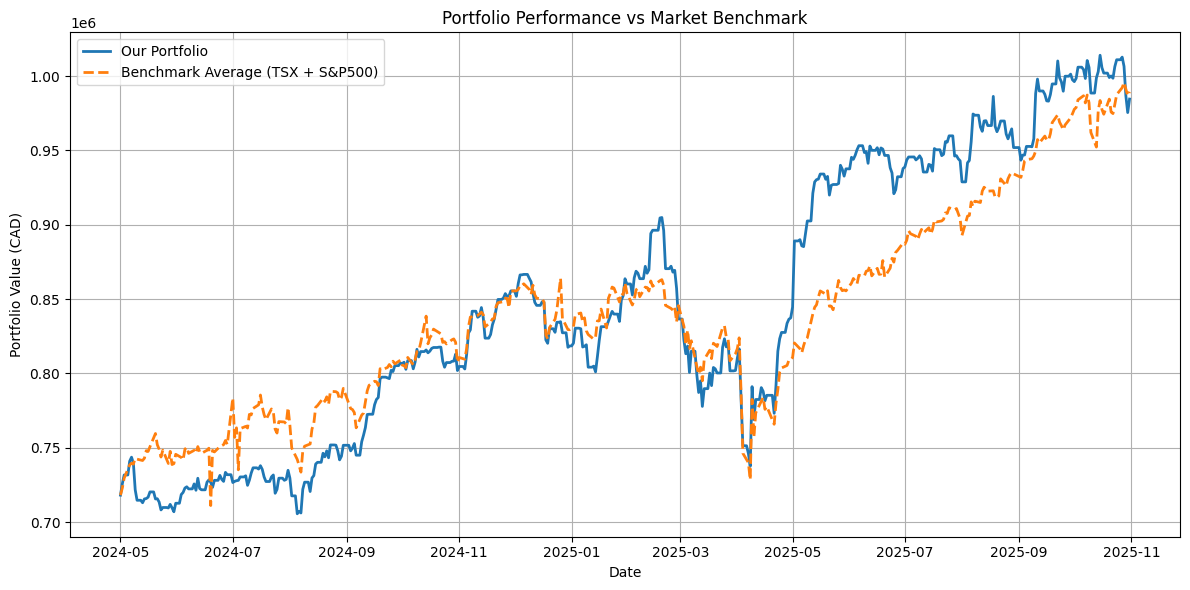

In [38]:
# Reconstruct Portfolio Value Over Time

start_date = "2024-05-01"
end_date   = "2025-11-01"

portfolio_prices = yf.download(
    list(portfolio_final["Ticker"]),
    start=start_date,
    end=end_date
)["Close"]

portfolio_prices = portfolio_prices.asfreq("1D")  # ensure daily calendar
portfolio_prices = portfolio_prices.fillna(method="ffill")
portfolio_prices = portfolio_prices.fillna(method="bfill")

# If only one ticker, convert to DataFrame
if isinstance(portfolio_prices, pd.Series):
    portfolio_prices = portfolio_prices.to_frame()

# Convert all USD prices to CAD
for ticker in portfolio_prices.columns:
    if ".TO" not in ticker:  # USD ticker
        portfolio_prices[ticker] = portfolio_prices[ticker] * usd_to_cad

shares_dict = dict(zip(portfolio_final["Ticker"], portfolio_final["Shares"]))
portfolio_value_series = (portfolio_prices * pd.Series(shares_dict)).sum(axis=1)

# Benchmark Performance Series

benchmark_tickers = ["^GSPTSE", "^GSPC"]

benchmark_prices = yf.download(
    benchmark_tickers,
    start=start_date,
    end=end_date
)["Close"]

# Convert S&P500 (USD) to CAD
benchmark_prices["^GSPC"] = benchmark_prices["^GSPC"] * usd_to_cad

# Normalize to 1 at start
benchmark_norm = benchmark_prices / benchmark_prices.iloc[0]

# Arithmetic average of both index normalized curves
benchmark_series = benchmark_norm.mean(axis=1)

# Scale benchmark to $1,000,000 (same as portfolio)
benchmark_value_series = benchmark_series * portfolio_value_series.iloc[0]


# Plot

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_series.index, portfolio_value_series.values,
         label="Our Portfolio", linewidth=2)
plt.plot(benchmark_value_series.index, benchmark_value_series.values,
         label="Benchmark Average (TSX + S&P500)", linewidth=2, linestyle='--')

plt.title("Portfolio Performance vs Market Benchmark")
plt.ylabel("Portfolio Value (CAD)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Portfolio return
portfolio_start = portfolio_value_series.iloc[0]
portfolio_end   = portfolio_value_series.iloc[-1]
portfolio_return = (portfolio_end - portfolio_start) / portfolio_start * 100

# Benchmark return
benchmark_start = benchmark_value_series.iloc[0]
benchmark_end   = benchmark_value_series.iloc[-1]
benchmark_return = (benchmark_end - benchmark_start) / benchmark_start * 100

print(f"Portfolio Return: {portfolio_return:.2f}%")
print(f"Benchmark Return: {benchmark_return:.2f}%")

Portfolio Return: 37.10%
Benchmark Return: 37.78%


##### Portfolio's Performance

The graph compares the performance of the constructed portfolio to the market benchmark, defined as the combined S&P~500 and TSX Composite indices, over the past year. As illustrated by the blue line (portfolio) and the orange line (market benchmark), both series exhibit similar movements over time, rising and declining during the same periods. This close co-movement is consistent with the objectives of a Market-Meet strategy, where the goal is to track overall market behaviour rather than to exceed it.

Over the evaluation period, the portfolio achieved an expected return of $37.10\%$, while the benchmark returned $37.78\%$. The proximity of these values indicates that the portfolio successfully captures the general return characteristics of the broader market. Furthermore, the slightly smoother trajectory of the portfolio suggests a more stable response to market fluctuations, reflecting the influence of model-driven price forecasts and the disciplined weight constraints applied during the Monte Carlo allocation process.

In [40]:
stocks_final = pd.concat([portfolio_final['Ticker'],portfolio_final['Shares']], axis=1)
stocks_final.to_csv('Final_Portfolio.csv')
stocks_final

,Ticker,Shares
1,DUOL,316.5885
2,GOOG,148.4907
3,EXE.TO,1674.5055
4,SPG,99.9177
5,RY.TO,113.5479
6,ORCL,222.2080
7,BK,227.1025
8,TD.TO,215.0660
9,TD,415.3434
10,GCT,443.5940
